# Manage user info

In [1]:
# 初期化
from pymongo import MongoClient
from constants import Constants

mongo_uri = f"mongodb://{Constants.USER}:{Constants.PASSWORD}@{Constants.MONGO_HOST}:{Constants.MONGO_PORT}/"
client = MongoClient(mongo_uri)

## 要件1: ユーザーの名前とメールアドレスを管理する

以下のような構造のデータを作成する。

```json
{
  "user_id": "1",
  "name": "John Doe",
  "email": "johndoe@example.com",
}
```


### ケース1: ユーザーデータを1件単位で登録

ユーザーがWeb画面で入力した値を1件ずつ登録するといったケースでは以下のようなコードを書く。

In [2]:
# DBを取得。無ければ自動作成される。
db=client["manage_user_info"]
# コレクションとして`user`を取得、無ければ自動作成。insert_one()で値を挿入
db.user.insert_one({'user_id': "1", 'name': "John Doe", "email": "johndoe@example.com"})
# userコレクションから値を一つ取得
db.user.find_one()


{'_id': ObjectId('6706373d59e694ecdda9e5ce'),
 'user_id': '1',
 'name': 'John Doe',
 'email': 'johndoe@example.com'}

In [3]:
# 重複を許容しない場合、キーを指定して値をupsertする
user2={'user_id': "2", 'name': "Jane Doe", "email": "janedoe@example.com"}
db.user.update_one({'email': "janedoe@example.com"}, {"$set": user2}, upsert=True)
# find()で値を検索できる
user2=db.user.find({'email': "janedoe@example.com"}).next()
print(f"初期値: {user2}")
# 名前を変えてみる
user2['name'] =  "John Doe"
db.user.update_one({'email': "janedoe@example.com"}, {"$set": user2}, upsert=True)
user2=db.user.find({'email': "janedoe@example.com"}).next()
print(f"変更値: {user2}")

初期値: {'_id': ObjectId('6706373d672bd4846b207712'), 'email': 'janedoe@example.com', 'name': 'Jane Doe', 'user_id': '2'}
変更値: {'_id': ObjectId('6706373d672bd4846b207712'), 'email': 'janedoe@example.com', 'name': 'John Doe', 'user_id': '2'}


Mongo Expressで見ると以下の画像のような状態になっている。

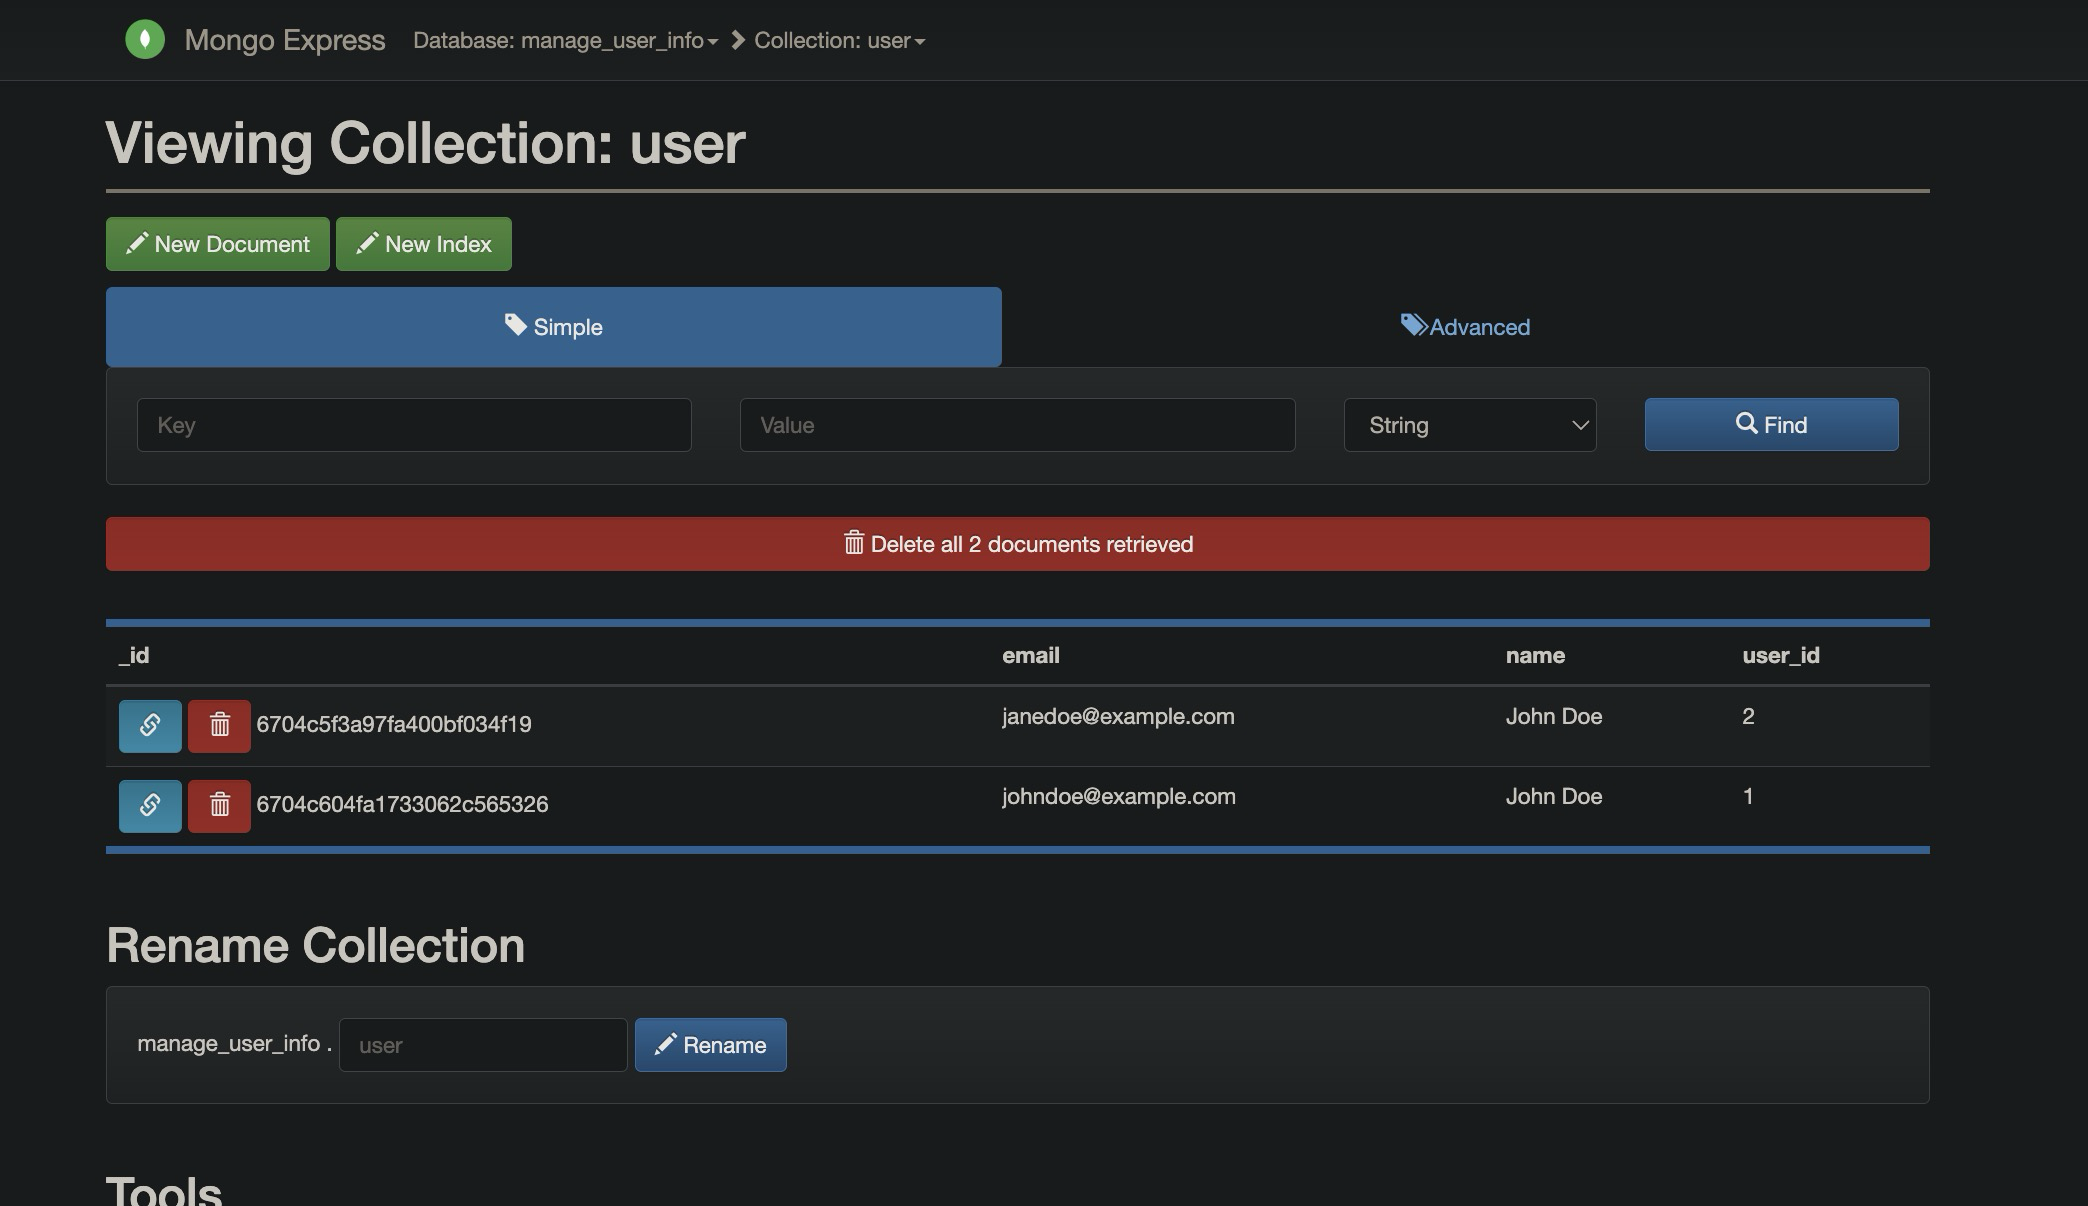

In [4]:
# 次のケースに移るために一旦コレクションを空にする
db.user.delete_many({})
db.user.find_one()

### ケース2: ユーザーデータを一括登録

別システムや名簿などから抽出したデータを元に一括登録するといったケースでは以下のようなコードを書く。

In [5]:
import os
from pathlib import Path
import json
from pymongo.collection import Collection
# 本例ではdatフォルダに配置したjsonファイルを取り込む
dat_dir = Path(Path().resolve().parent.parent.parent, 'dat')
user_data_path = Path(dat_dir, 'user_v1.json')
print(f'{user_data_path=}')

# 一括取り込み関数を定義
def insert_from_json_file(collection: Collection, json_file_path:str):
    with open(json_file_path, 'r') as f:
        json_data=json.load(f)
        print(f'{json_data=}')
        collection.insert_many(json_data)

insert_from_json_file(db.user,user_data_path)

user_data_path=PosixPath('/usr/src/app/dat/user_v1.json')
json_data=[{'user_id': '1', 'name': 'John Doe', 'email': 'johndoe@example.com'}, {'user_id': '2', 'name': 'Jane Doe', 'email': 'janedoe@example.com'}, {'user_id': '3', 'name': 'Sam Smith', 'email': 'samsmith@example.com'}, {'user_id': '4', 'name': 'Emma Watson', 'email': 'emmawatson@example.com'}, {'user_id': '5', 'name': 'Tom Hanks', 'email': 'tomhanks@example.com'}, {'user_id': '6', 'name': 'Scarlett Johansson', 'email': 'scarjohanson@example.com'}, {'user_id': '7', 'name': 'Hugh Jackman', 'email': 'hughjackman@example.com'}, {'user_id': '8', 'name': 'Angelina Jolie', 'email': 'angelinajolie@example.com'}, {'user_id': '9', 'name': 'Brad Pitt', 'email': 'bradpitt@example.com'}, {'user_id': '10', 'name': 'Jennifer Aniston', 'email': 'jenaniston@example.com'}]


Mongo Expressで見た状態

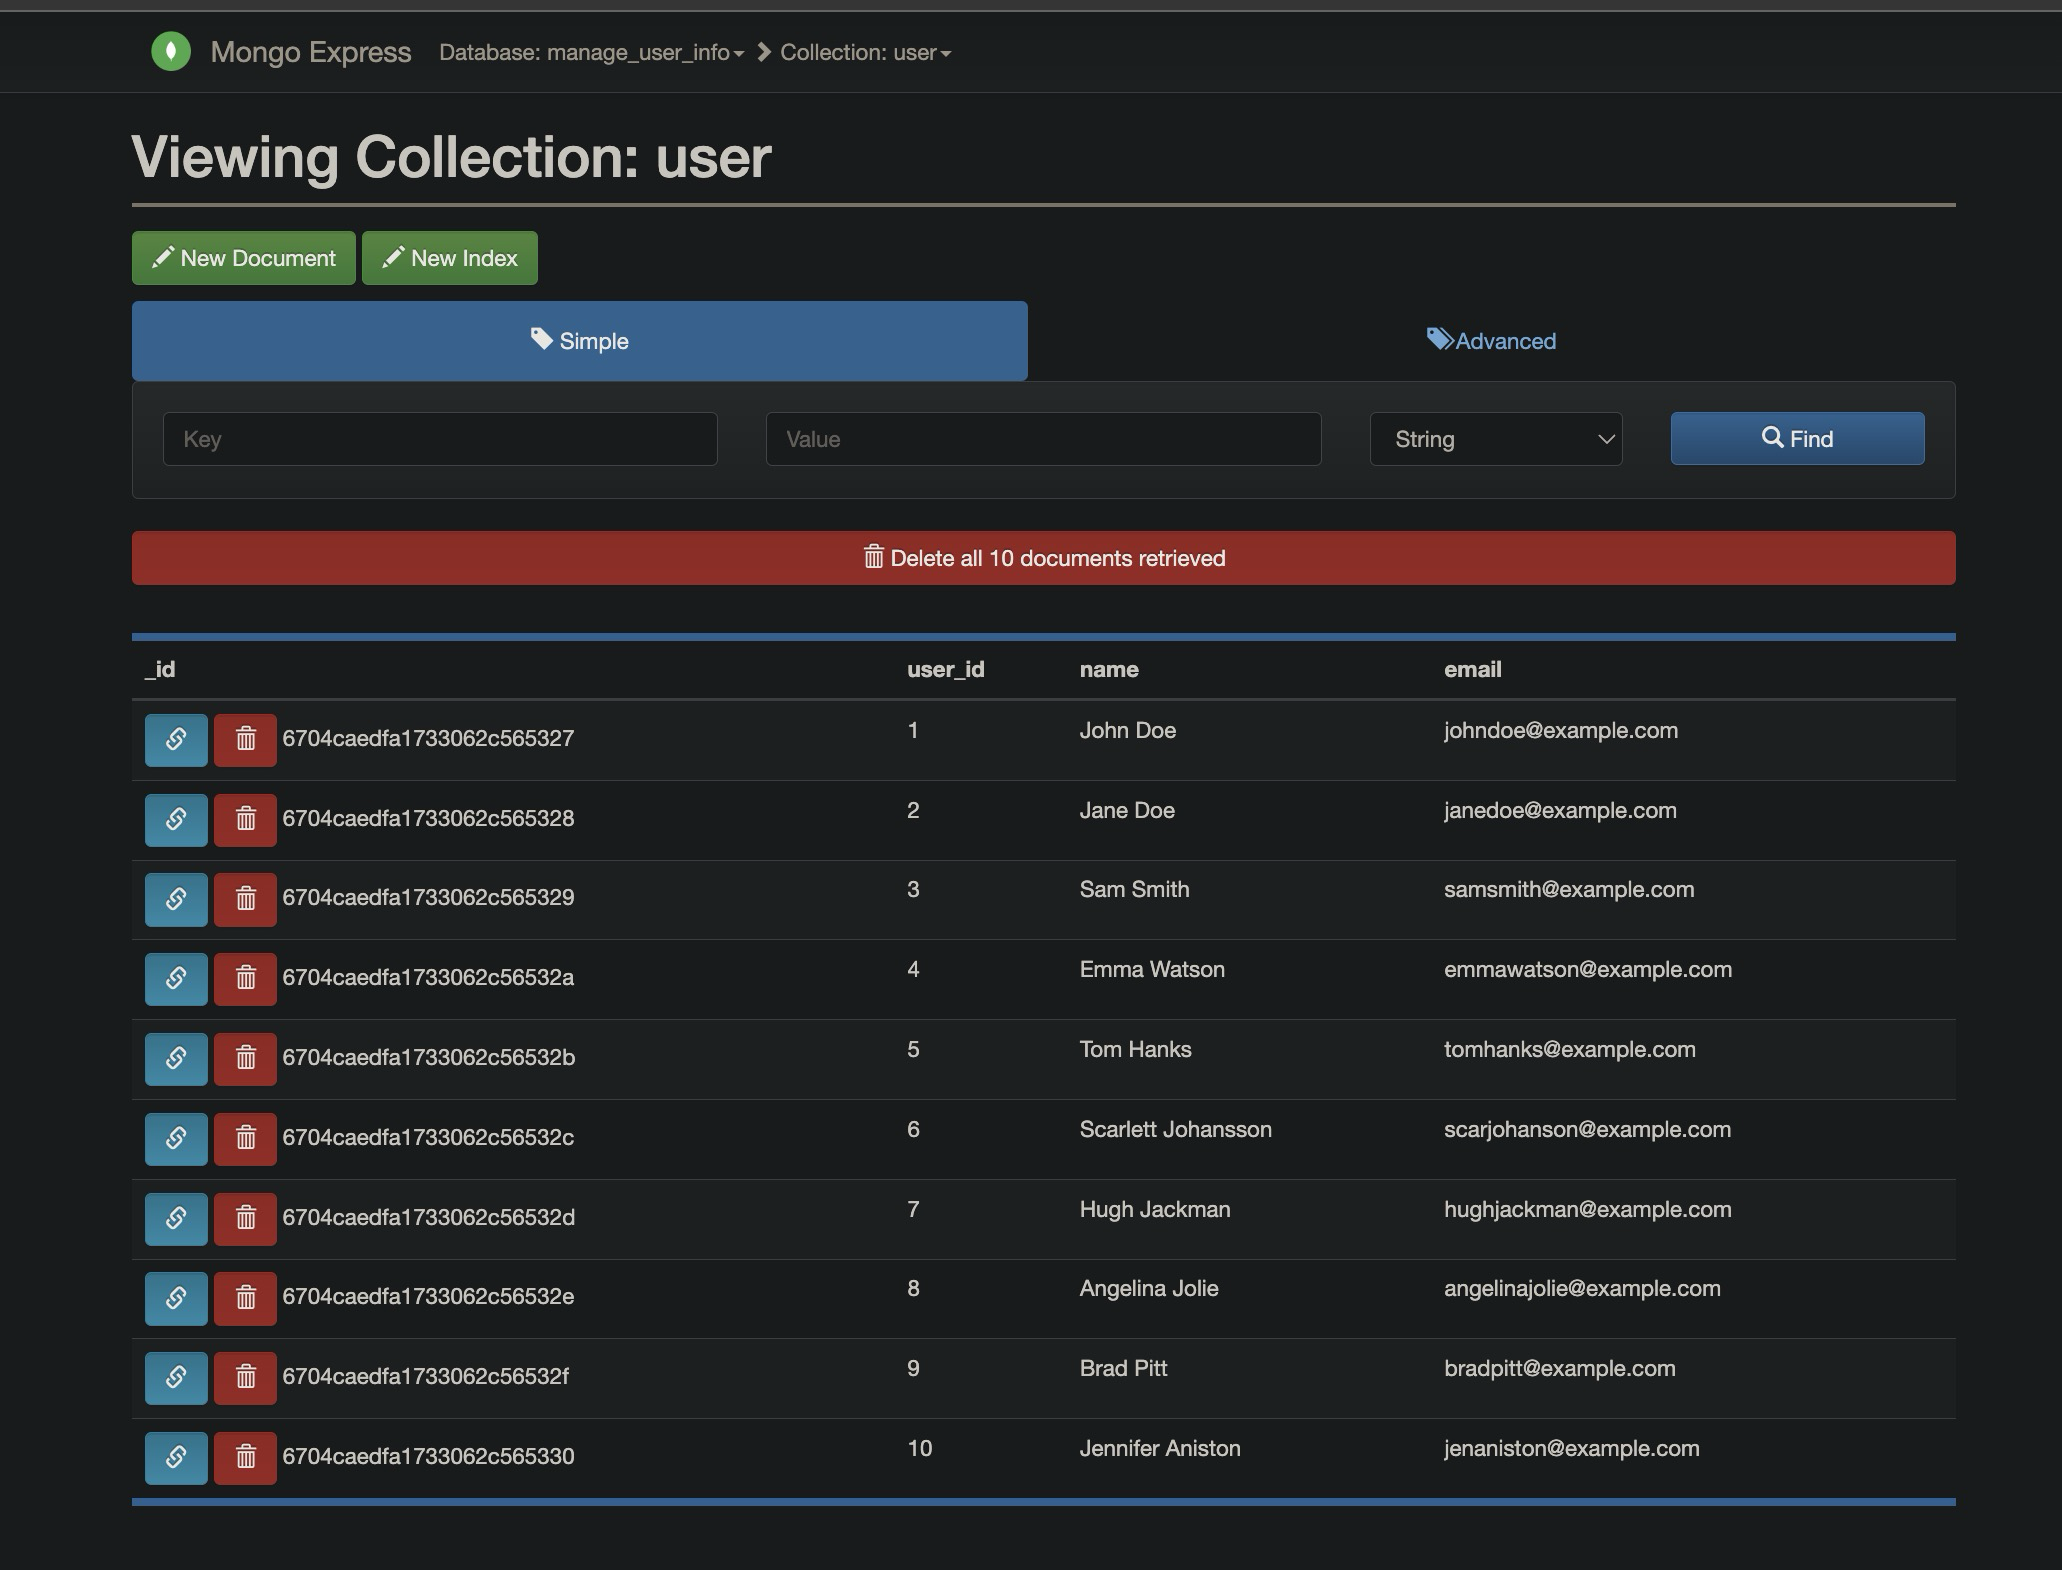

## 要件2: 新たに企業情報を追加し、ユーザー情報との紐づけを行う

- 階層構造で構成されるような情報を壊さずにそのまま保管したい場合はNoSQLに軍配が上がる。
- アジャイル開発など、要件が流動的な案件ではシステムの仕様変更に併せてDB構造も変わっていく。
RDBではそういった場合、alembicなどのマイグレーションツールを利用して、DBのバージョン管理を行うことでスキーマを管理する。
しかし、仕様変更の頻度が頻繁、あるいは規模が大きいと管理にかかるコストが膨大になってしまう。
NoSQLというスキーマレスなDBであれば、その辺りの管理コストを削減できる。

### ケース3: 企業情報を追加する

#### 企業情報コレクション構造(company collection)

```json
{
  "name": "Tech Corp",
  "departments": [
    {
      "name": "Engineering",
      "head": "Jane Doe"
    },
  ],
  "subsidiaries": [
    {
      "name": "Tech Corp 2",
      "departments": [
        {
          "name": "Product",
          "head": "Jake Kim"
        },
      ]
    }
  ]
}
```

- 企業名、部門のリスト、子会社のリストで構成する
- 子会社は必ずしもあるわけではない。子会社がない場合はsubsidiaries属性を省略する。


In [6]:
# 企業情報コレクションの作成
# ケース2で作成したbulk_insert_from_json_file()を再利用してファイルからデータを取り込む。
company_data_path = Path(dat_dir, 'company.json')
print(f'{company_data_path=}')

insert_from_json_file(db.company,company_data_path)

company_data_path=PosixPath('/usr/src/app/dat/company.json')
json_data=[{'name': 'Tech Corp', 'departments': [{'name': 'Engineering', 'head': 'Jane Doe'}, {'name': 'Sales', 'head': 'John Smith'}], 'subsidiaries': [{'name': 'Tech Branch Corp 1', 'departments': [{'name': 'Product', 'head': 'Jake Kim'}, {'name': 'Marketing', 'head': 'Claire Lee'}]}, {'name': 'Tech Branch Corp 2', 'departments': [{'name': 'IT', 'head': 'Emma Jones'}, {'name': 'Human Resources', 'head': 'Henry Brown'}]}]}, {'name': 'Biz Corp', 'departments': [{'name': 'Sales', 'head': 'Alex Johnson'}, {'name': 'Customer Service', 'head': 'Lucia Rodriguez'}], 'subsidiaries': [{'name': 'Biz Branch Corp 1', 'departments': [{'name': 'IT', 'head': 'Ethan Miller'}, {'name': 'Research', 'head': 'Sophia Davis'}]}]}, {'name': 'Art Corp', 'departments': [{'name': 'Design', 'head': 'Ava Martinez'}, {'name': 'Production', 'head': 'William Garcia'}, {'name': 'Sales', 'head': 'Sam Smith'}]}]


Mongo Expressで見た状態

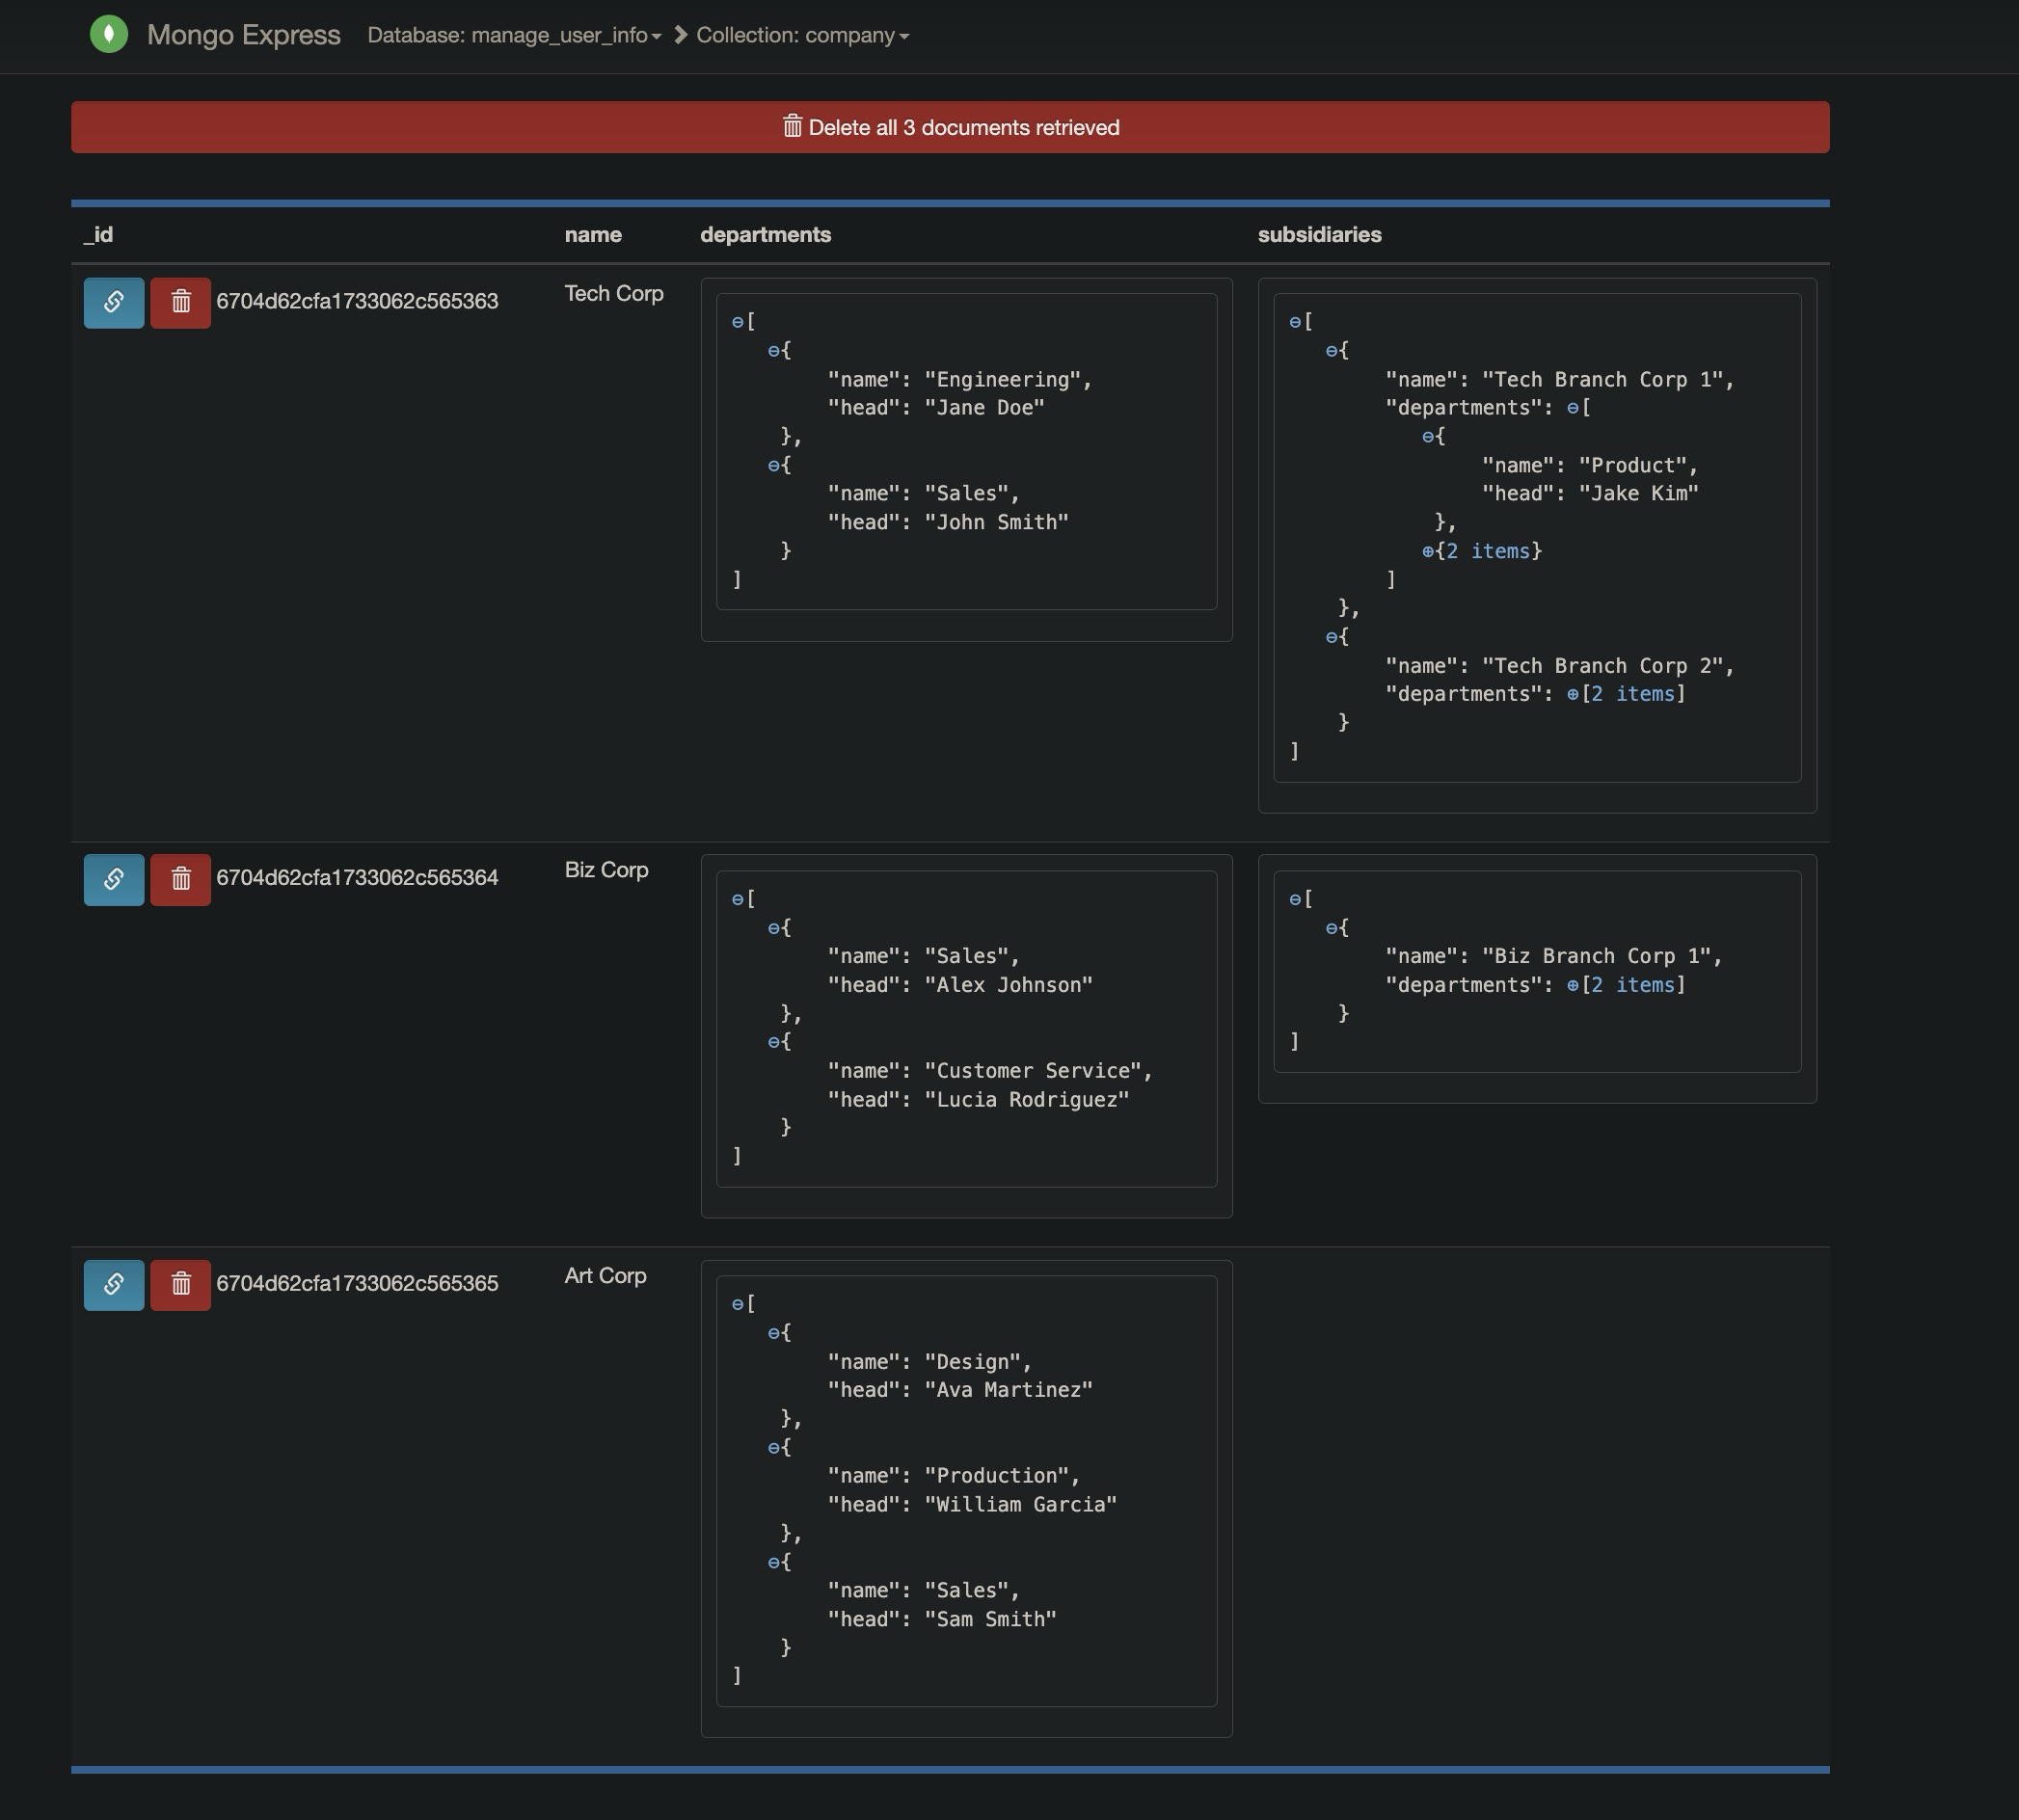

#### 新たなユーザーコレクション構造(user collection)

```json
{
  "user_id": "1",
  "name": "John Doe",
  "email": "johndoe@example.com",
  "affiliation":{
    "campany": "Tech Corp",
    "department": "Engineering",
    "role": "Engineer",
  },
}
```

- 所属(affiliation)情報を追加する。
  - companyとdepartmentは企業情報コレクションと対応する。idで照合するような強い紐づけではなく、名前で照合し、企業情報コレクションに存在しない値がセットされていても許容する。
- 既存のデータは残したままにして、情報が不足していてもエラーデータとしては扱わない
- メールアドレスを一意なキーとして、既存データがあれば置き換える。無ければ新規作成


In [7]:
dat_dir = Path(Path().resolve().parent.parent.parent, 'dat')
user_data_path = Path(dat_dir, 'user_v2.json')
print(f'{user_data_path=}')

# キー指定の一括取り込み関数を定義
def insert_from_json_file_with_key(collection: Collection, key: str, json_file_path:str):
    with open(json_file_path, 'r') as f:
        json_data=json.load(f)
        print(f'{json_data=}')
        for item in json_data:
            fillter= {key: item[key]}
            collection.update_one(fillter, {"$set": item}, upsert=True)

insert_from_json_file_with_key(db.user,"email",user_data_path)


user_data_path=PosixPath('/usr/src/app/dat/user_v2.json')
json_data=[{'user_id': '11', 'name': 'John Doe', 'email': 'johndoe@example.com', 'affiliation': {'company': 'Tech Corp', 'department': 'Engineering', 'role': 'Engineer'}}, {'user_id': '12', 'name': 'Jane Doe', 'email': 'janedoe@example.com', 'affiliation': {'company': 'Art Corp', 'department': 'Design', 'role': 'Designer'}}, {'user_id': '13', 'name': 'Sam Smith', 'email': 'samsmith@example.com', 'affiliation': {'company': 'Tech Branch Corp 2', 'department': 'Human Resources', 'role': 'HR Manager'}}, {'user_id': '14', 'name': 'Emma Jones', 'email': 'emmajones@example.com', 'affiliation': {'company': 'Tech Branch Corp 1', 'department': 'Marketing', 'role': 'Marketing Manager'}}, {'user_id': '15', 'name': 'Oliver Brown', 'email': 'oliverbrown@example.com', 'affiliation': {'company': 'Biz Corp', 'department': 'Sales', 'role': 'Sales Manager'}}, {'user_id': '16', 'name': 'Sophia Davis', 'email': 'sophiadavis@example.com', 'affiliatio

Mongo Expressで見た状態

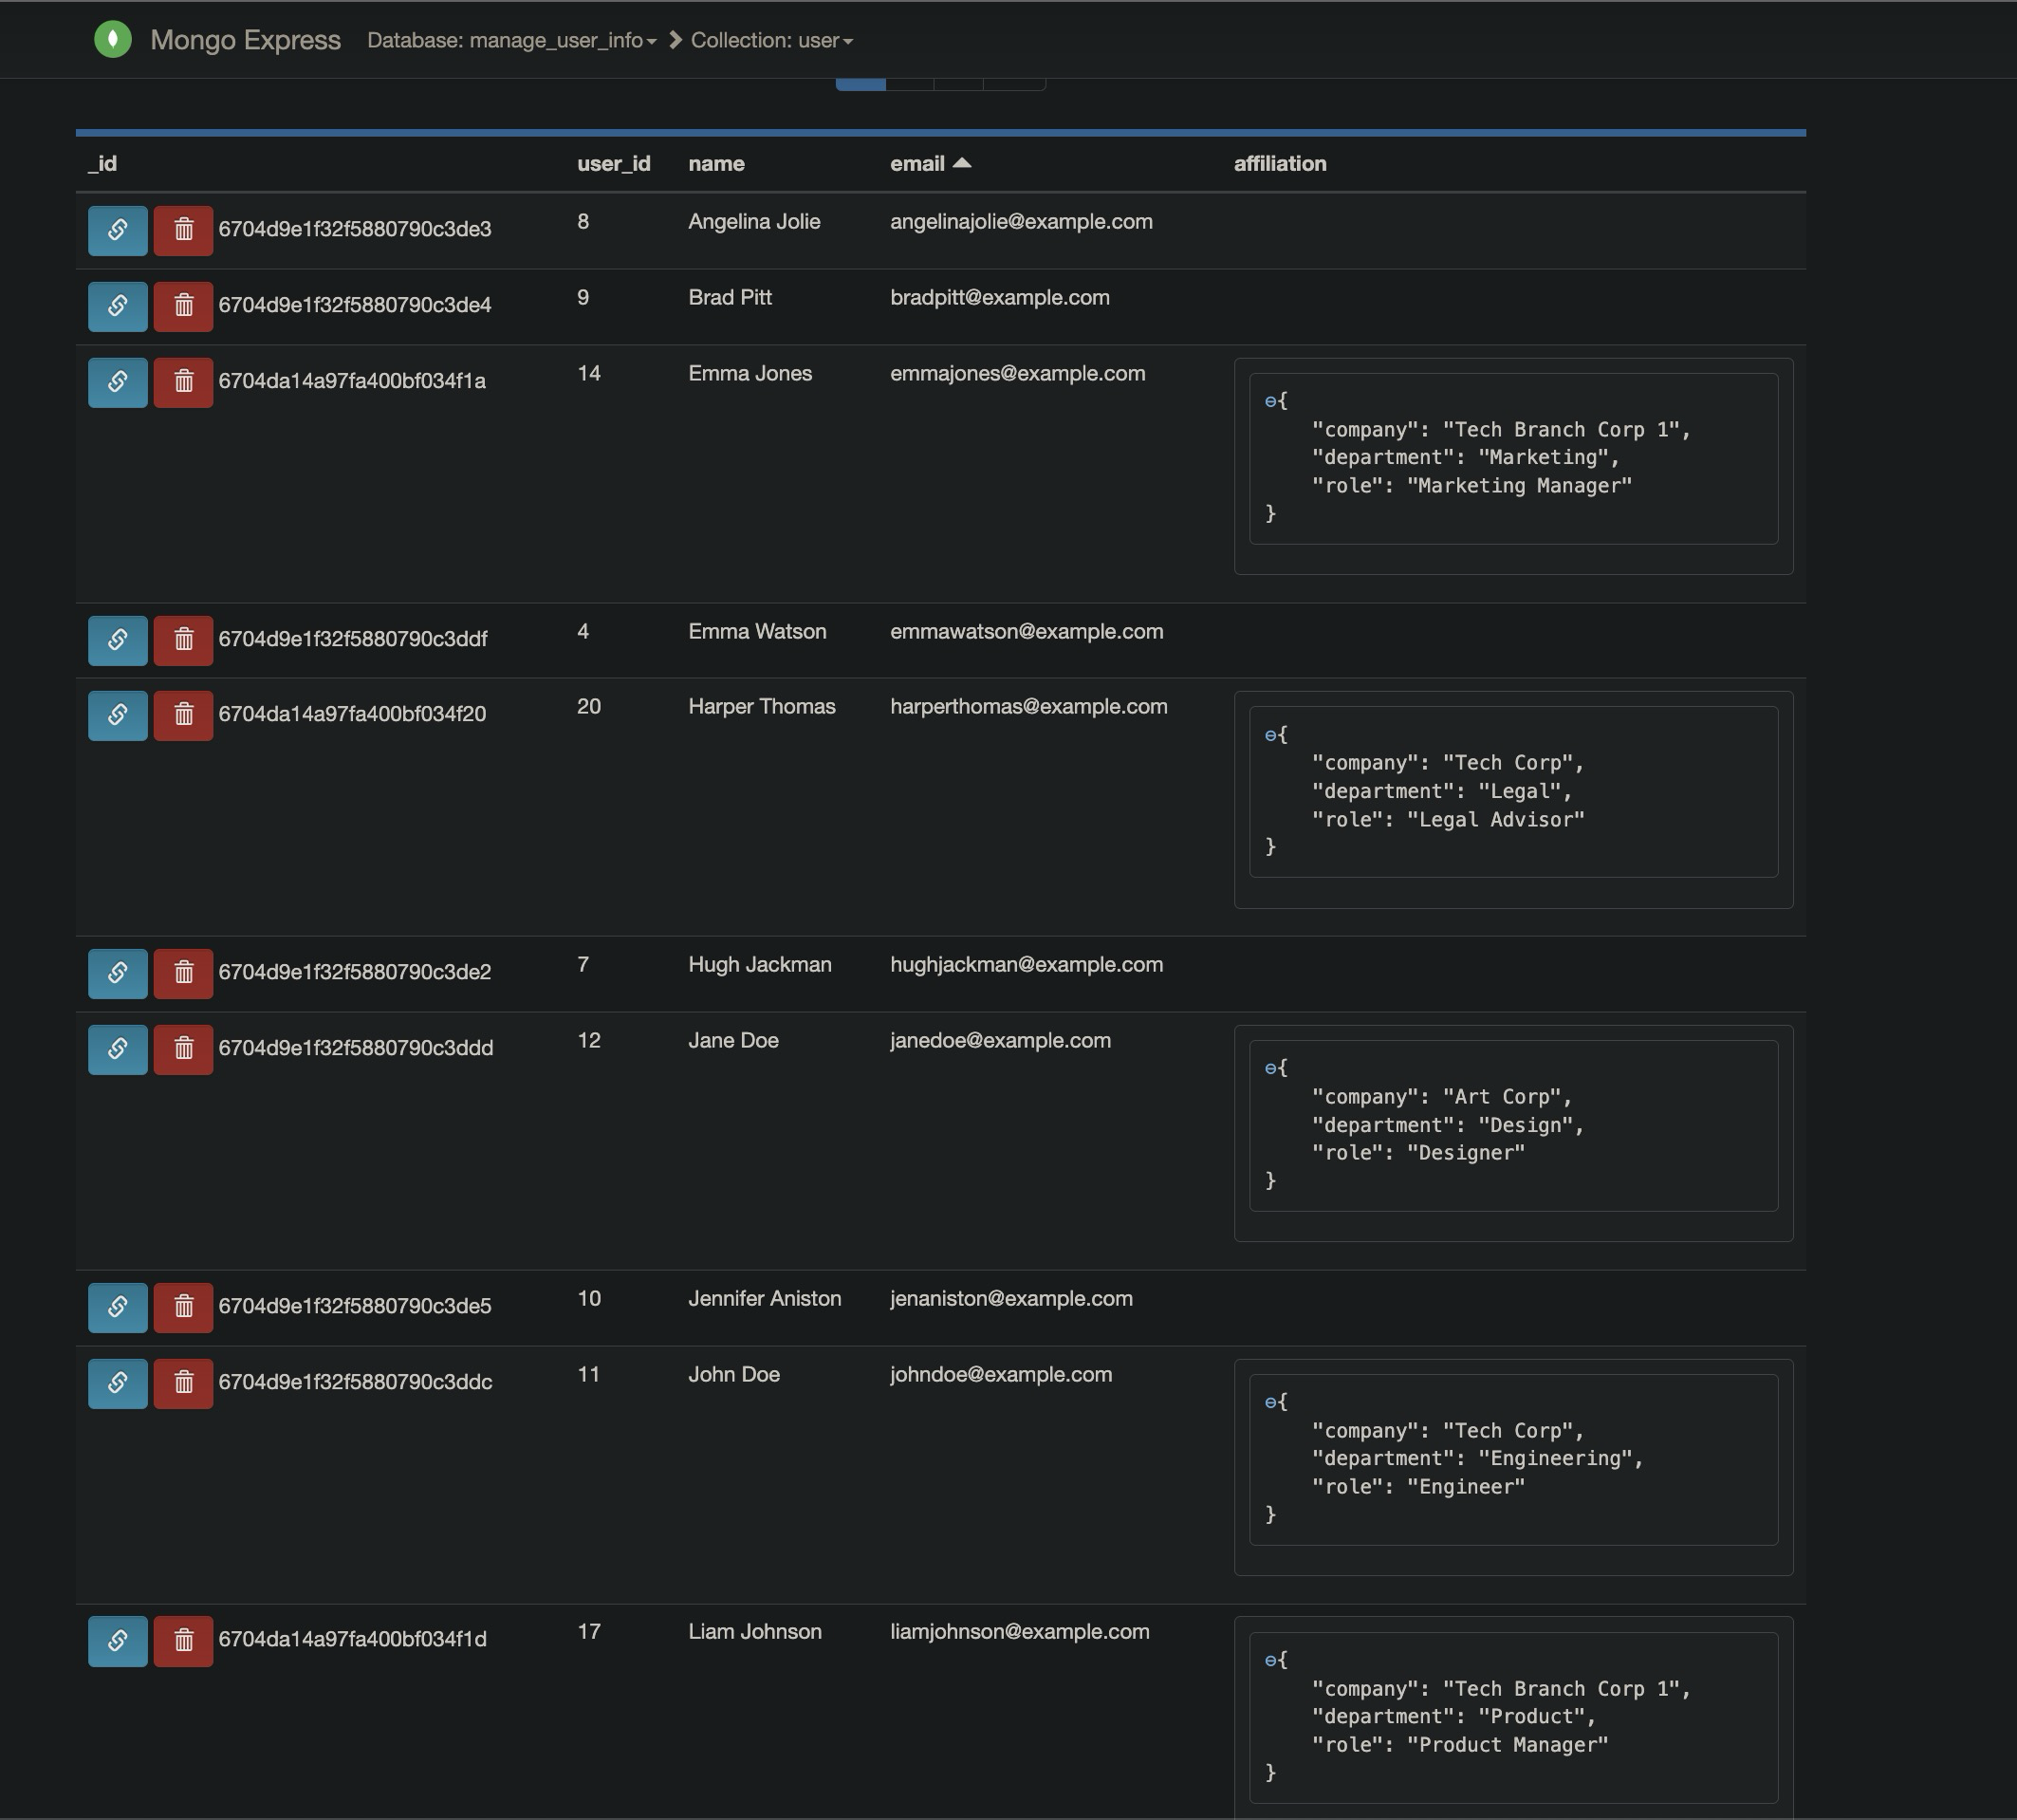

- 異なる構造のデータが共存している
- 既存のデータが置き換えられているのと同時に新しいデータが追加されている

### ケース4: 様々な条件検索を行う

In [8]:
#　いずれかの親会社に属するユーザー
pipeline1= [
    {
        "$lookup": {
            "from": "company",
            "localField": "affiliation.company",
            "foreignField": "name",
            "as": "company_info"
        },
    },
    {"$project":{"user_id":1,"name":1 , "affiliation": {"company":1}, "company_info":{"name": 1}}},
    {
        "$unwind": "$company_info"
    }
]
for item in (db.user.aggregate(pipeline1)):
    print(item)


{'_id': ObjectId('6706373d59e694ecdda9e5cf'), 'user_id': '11', 'name': 'John Doe', 'affiliation': {'company': 'Tech Corp'}, 'company_info': {'name': 'Tech Corp'}}
{'_id': ObjectId('6706373d59e694ecdda9e5d0'), 'user_id': '12', 'name': 'Jane Doe', 'affiliation': {'company': 'Art Corp'}, 'company_info': {'name': 'Art Corp'}}
{'_id': ObjectId('6706373d672bd4846b207714'), 'affiliation': {'company': 'Biz Corp'}, 'name': 'Oliver Brown', 'user_id': '15', 'company_info': {'name': 'Biz Corp'}}
{'_id': ObjectId('6706373d672bd4846b207715'), 'affiliation': {'company': 'Tech Corp'}, 'name': 'Sophia Davis', 'user_id': '16', 'company_info': {'name': 'Tech Corp'}}
{'_id': ObjectId('6706373d672bd4846b207719'), 'affiliation': {'company': 'Tech Corp'}, 'name': 'Harper Thomas', 'user_id': '20', 'company_info': {'name': 'Tech Corp'}}


In [9]:
#　いずれかの子会社に属するユーザー
pipeline2= [
    {
        "$lookup": {
            "from": "company",
            "let": {
                "name": "$affiliation.company"
            },
            "pipeline": [
                {
                    "$unwind": "$subsidiaries"
                },
                {
                    "$match": {
                        "$expr": {
                            "$eq": [
                                "$subsidiaries.name",
                                "$$name"
                            ]
                        }
                    }
                },
                {"$project":{ "subsidiaries":{"name":1}}},
            ],
            "as": "company_info"
        },

    },
     {"$project":{"user_id":1,"name":1 , "affiliation": {"company":1}, "company_info":1}},
    {
        "$unwind": "$company_info"
    }
]
for item in (db.user.aggregate(pipeline2)):
    print(item)

{'_id': ObjectId('6706373d59e694ecdda9e5d1'), 'user_id': '13', 'name': 'Sam Smith', 'affiliation': {'company': 'Tech Branch Corp 2'}, 'company_info': {'_id': ObjectId('6706373d59e694ecdda9e5d9'), 'subsidiaries': {'name': 'Tech Branch Corp 2'}}}
{'_id': ObjectId('6706373d672bd4846b207713'), 'affiliation': {'company': 'Tech Branch Corp 1'}, 'name': 'Emma Jones', 'user_id': '14', 'company_info': {'_id': ObjectId('6706373d59e694ecdda9e5d9'), 'subsidiaries': {'name': 'Tech Branch Corp 1'}}}
{'_id': ObjectId('6706373d672bd4846b207716'), 'affiliation': {'company': 'Tech Branch Corp 1'}, 'name': 'Liam Johnson', 'user_id': '17', 'company_info': {'_id': ObjectId('6706373d59e694ecdda9e5d9'), 'subsidiaries': {'name': 'Tech Branch Corp 1'}}}
{'_id': ObjectId('6706373d672bd4846b207718'), 'affiliation': {'company': 'Biz Branch Corp 1'}, 'name': 'Noah Williams', 'user_id': '19', 'company_info': {'_id': ObjectId('6706373d59e694ecdda9e5da'), 'subsidiaries': {'name': 'Biz Branch Corp 1'}}}


In [10]:
#　いずれかの子会社に属するHeadがHenry Brownのユーザー
pipeline3= [
    {
        "$lookup": {
            "from": "company",
            "let": {
                "name": "$affiliation.company",
                "department": "$affiliation.department",
            },
            "pipeline": [
                {
                    "$unwind": "$subsidiaries"
                },
                {
                    "$unwind": "$subsidiaries.departments"
                },
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                {
                                    "$eq": [
                                        "$subsidiaries.name",
                                        "$$name"
                                    ]
                                },
                                {
                                    "$eq": [
                                        "$subsidiaries.departments.name",
                                        "$$department"
                                    ]
                                },
                                {
                                    "$eq": [
                                        "$subsidiaries.departments.head",
                                        "Henry Brown"
                                    ]
                                },
                            ]
                        }
                    }
                },
                {
                    "$project": {
                        "subsidiaries": {
                            "departments": {
                                "name": 1,
                                "head": 1
                            }
                        }
                    }
                },
            ],
            "as": "company_info"
        }
    },
    {"$project":{"user_id":1,"name":1 , "affiliation": {"company":1, "department":1}, "company_info":1}},
    {
        "$unwind": "$company_info"
    },
]
for item in (db.user.aggregate(pipeline3)):
    print(item)


{'_id': ObjectId('6706373d59e694ecdda9e5d1'), 'user_id': '13', 'name': 'Sam Smith', 'affiliation': {'company': 'Tech Branch Corp 2', 'department': 'Human Resources'}, 'company_info': {'_id': ObjectId('6706373d59e694ecdda9e5d9'), 'subsidiaries': {'departments': {'name': 'Human Resources', 'head': 'Henry Brown'}}}}


In [11]:
# DBをクリーンアップする
db.user.delete_many({})
db.company.delete_many({})

DeleteResult({'n': 3, 'ok': 1.0}, acknowledged=True)